# Homework 4

First import required libraries

In [6]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

### Question 1

First, load in the relational data:

In [7]:
multilevel_lookup = pd.read_csv("https://raw.githubusercontent.com/bcaffo/MRIcloudT1volumetrics/master/inst/extdata/multilevel_lookup_table.txt", sep = "\t").drop(['Level5'], axis = 1)
multilevel_lookup = multilevel_lookup.rename(columns = {
    "modify"   : "roi", 
    "modify.1" : "level4",
    "modify.2" : "level3", 
    "modify.3" : "level2",
    "modify.4" : "level1"})
multilevel_lookup = multilevel_lookup[['roi', 'level4', 'level3', 'level2', 'level1']]
multilevel_lookup[multilevel_lookup.level4 == multilevel_lookup.roi]

,roi,level4,level3,level2,level1
0,SFG_L,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L
1,SFG_R,SFG_R,Frontal_R,CerebralCortex_R,Telencephalon_R
6,MFG_L,MFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L
7,MFG_R,MFG_R,Frontal_R,CerebralCortex_R,Telencephalon_R
20,RG_L,RG_L,Frontal_L,CerebralCortex_L,Telencephalon_L
...,...,...,...,...,...
272,TempSul_L,TempSul_L,TempSul_L,Sulcus_L,CSF
273,TempSul_R,TempSul_R,TempSul_R,Sulcus_R,CSF
274,Caudate_tail_L,Caudate_tail_L,BasalGang_L,CerebralNucli_L,Telencephalon_L
276,Caudate_tail_R,Caudate_tail_R,BasalGang_R,CerebralNucli_R,Telencephalon_R


Now we need the region data and we can merge this on. 

In [8]:
## Now load in the subject data
id = 127
subjectData = pd.read_csv("https://raw.githubusercontent.com/smart-stats/ds4bio_book/main/book/assetts/kirby21AllLevels.csv").drop(['Unnamed: 0'], axis = 1)
subjectData = subjectData.loc[(subjectData.type == 1) & (subjectData.level == 5) & (subjectData.id == id)]
subjectData = subjectData[['roi', 'volume']]
## Merge the subject data with the multilevel data
subjectData = pd.merge(subjectData, multilevel_lookup, on = "roi")
subjectData = subjectData.assign(comp = subjectData.volume / np.sum(subjectData.volume))
subjectData = subjectData.assign(icv = "ICV")
subjectData

,roi,volume,level4,level3,level2,level1,comp,icv
0,SFG_L,12926,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L,0.009350,ICV
1,SFG_R,10050,SFG_R,Frontal_R,CerebralCortex_R,Telencephalon_R,0.007270,ICV
2,SFG_PFC_L,12783,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L,0.009247,ICV
3,SFG_PFC_R,11507,SFG_R,Frontal_R,CerebralCortex_R,Telencephalon_R,0.008324,ICV
4,SFG_pole_L,3078,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L,0.002227,ICV
...,...,...,...,...,...,...,...,...
275,Chroid_LVetc_L,444,AnteriorLateralVentricle_L,LateralVentricle_L,Ventricle,CSF,0.000321,ICV
276,Chroid_LVetc_R,371,AnteriorLateralVentricle_R,LateralVentricle_R,Ventricle,CSF,0.000268,ICV
277,IV_ventricle,2700,IV_ventricle,IV_ventricle,Ventricle,CSF,0.001953,ICV
278,ECCL_L,292,inf_DPWM_L,InferiorWM_L,WhiteMatter_L,Telencephalon_L,0.000211,ICV


In [9]:
ICVData = subjectData.groupby('icv').comp.sum()
Level1Data = subjectData.groupby('level1').comp.sum().reset_index()
Level1Data = Level1Data.assign(source = "ICV", level = 1).rename(columns = {"level1":"target"})

Level2Data = subjectData.groupby('level2').comp.sum().reset_index()
Level2Data = pd.merge(Level2Data, multilevel_lookup[['level2', 'level1']].rename(columns = {"level1":"source"}).drop_duplicates(), on = "level2")
Level2Data = Level2Data.rename(columns = {"level2":"target"}).assign(level = 2)

Level3Data = subjectData.groupby('level3').comp.sum().reset_index()
Level3Data = pd.merge(Level3Data, multilevel_lookup[['level3', 'level2']].rename(columns = {"level2":"source"}).drop_duplicates(), on = "level3")
Level3Data = Level3Data.rename(columns = {"level3":"target"}).assign(level = 3)

Level4Data = subjectData.groupby('level4').comp.sum().reset_index()
Level4Data = pd.merge(Level4Data, multilevel_lookup[['level4', 'level3']].rename(columns = {"level3":"source"}).drop_duplicates(), on = "level4")
Level4Data = Level4Data.rename(columns = {"level4":"target"}).assign(level = 4)

Level5Data = subjectData.groupby('roi').comp.sum().reset_index()
Level5Data = pd.merge(Level5Data, multilevel_lookup[['roi', 'level4']].rename(columns = {"level4":"source"}).drop_duplicates(), on = "roi")
Level5Data = Level5Data.rename(columns = {"roi":"target"}).assign(level = 5)

## Just 4 levels for now
SankeyData = pd.concat([Level1Data, Level2Data, Level3Data, Level4Data])
SankeyData = SankeyData.assign(level_minus = SankeyData.level-1)
SankeyData = SankeyData.assign(source = SankeyData.source + " " + SankeyData.level_minus.astype(str), target = SankeyData.target + " " + SankeyData.level.astype(str))

SankeyData = SankeyData.assign(uniquelabel = SankeyData.source + "_" + SankeyData.target + "_" + SankeyData.level.astype(str))
SankeyData

,target,comp,source,level,level_minus,uniquelabel
0,CSF 1,0.079417,ICV 0,1,0,ICV 0_CSF 1_1
1,Diencephalon_L 1,0.008548,ICV 0,1,0,ICV 0_Diencephalon_L 1_1
2,Diencephalon_R 1,0.008362,ICV 0,1,0,ICV 0_Diencephalon_R 1_1
3,Mesencephalon 1,0.007430,ICV 0,1,0,ICV 0_Mesencephalon 1_1
4,Metencephalon 1,0.115313,ICV 0,1,0,ICV 0_Metencephalon 1_1
...,...,...,...,...,...,...
135,inf_DPWM_R 4,0.013124,InferiorWM_R 3,4,3,InferiorWM_R 3_inf_DPWM_R 4_4
136,midbrain_L 4,0.003577,midbrain_L 3,4,3,midbrain_L 3_midbrain_L 4_4
137,midbrain_R 4,0.003853,midbrain_R 3,4,3,midbrain_R 3_midbrain_R 4_4
138,post_DPWM_L 4,0.003183,PosteriorWM_L 3,4,3,PosteriorWM_L 3_post_DPWM_L 4_4


In [10]:
name_to_number_dict = {}
labels = []
lvl_dict = {
    'source': [],
    'target': [],
    'value': [],
}

for index, row in SankeyData.iterrows():
    if not row['source'] in name_to_number_dict : # Check if we've seen the value already
        labels.append(row['source'].split(' ')[0]) # add only new values to the list. .split splits at the space, only take first name
        name_to_number_dict[row['source']] = len(name_to_number_dict) # add modified name to dict
    if not row['target'] in name_to_number_dict :
        labels.append(row['target'].split(' ')[0])
        name_to_number_dict[row['target']] = len(name_to_number_dict)
    
    lvl_dict['source'].append(name_to_number_dict[row['source']])
    lvl_dict['target'].append(name_to_number_dict[row['target']])
    lvl_dict['value'].append(row['comp'])

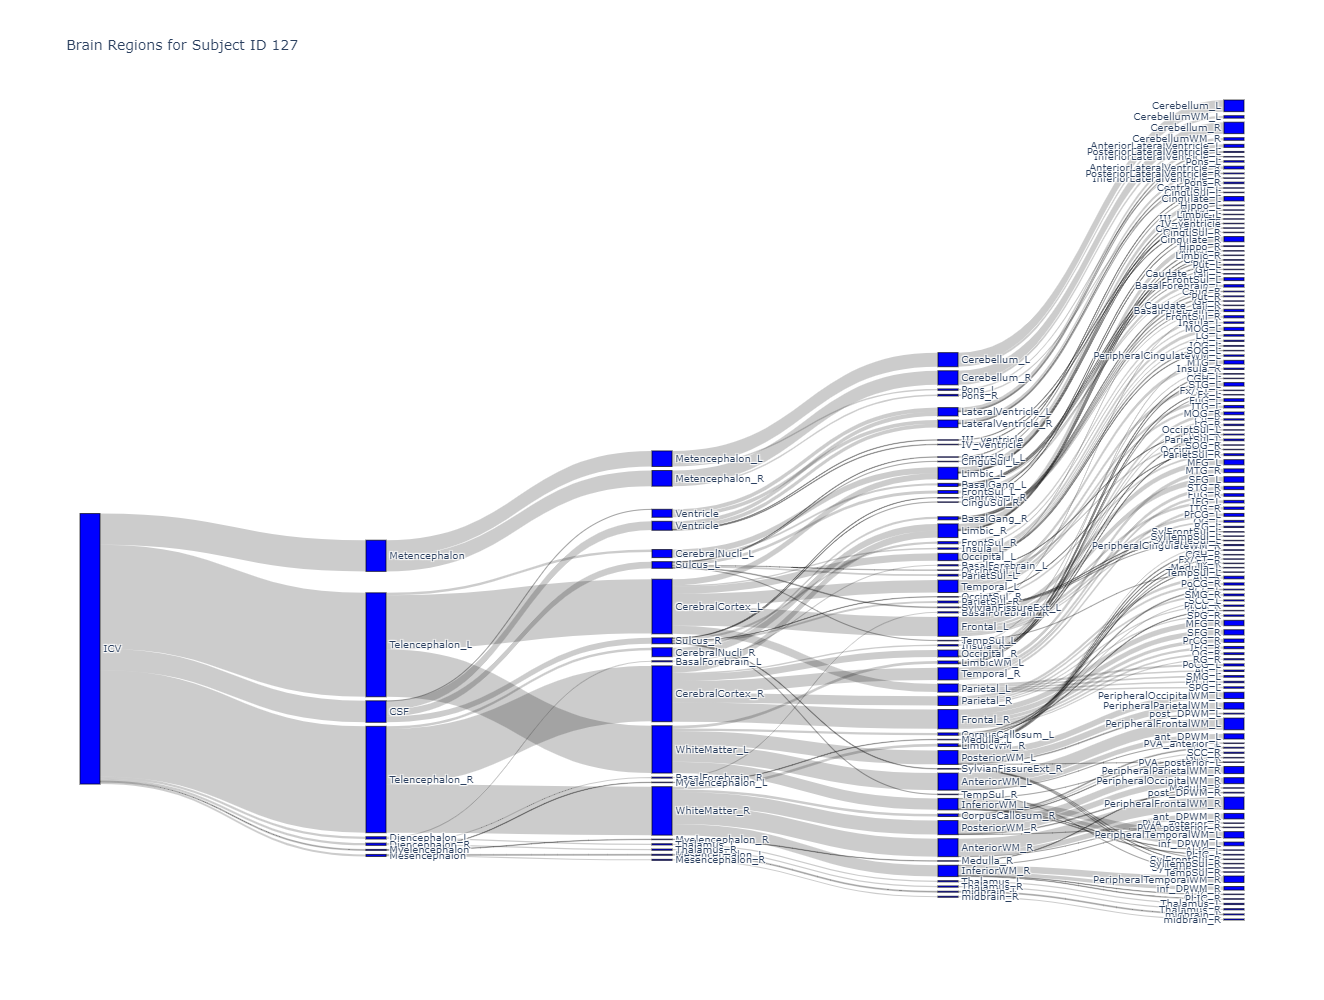

In [18]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = lvl_dict)])

fig.update_layout(title_text="Brain Regions for Subject ID 127", font_size=10,
                 autosize = False, width = 1100, height = 1000)
fig.show()